# Analyzing Changes in Electorate by Location

### Summary

This notebook analyzes trends related to the gender of the Brazilian electorate, looking into how the gender distribution of immigrant Brazilian voters has changed over time.


## Importing and Cleaning Data

The following code imports the relevant packages/code and cleans the individual datasets as necessary.


In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from data_cleaning.country_match import country_code_map as geomap
from data_cleaning import cleaning_utilities

In [2]:
def extract_dataframe(path: str, remove_extra_header=False):
    """
    Creates a Pandas Data Frame from a CSV File and makes headers uniform (lower cases, separated by _ vs space)
    :param path - A path to a CSV File
    :param remove_extra_header - A boolean to indicate if there is an extra header (Portuguese) which can be removed
    :return a Pandas dataframe
    """
    
    df = pd.DataFrame()
    
    if remove_extra_header:
        df = pd.read_csv(path, skiprows=[1])
        new_column_names = [x.lower().replace(' ','_') for x in df.columns]
        df.columns = new_column_names
        
    else:
        df = pd.read_csv(path)
        new_column_names = [x.lower().replace(' ','_') for x in df.columns]
        df.columns = new_column_names
        
    
    #Remove accents from country names
    df['country_name'] = df.apply(cleaning_utilities.remove_accents, axis=1)
    df = df.drop(columns=['municipality_name'])
    df = df.rename(columns={"country_name": "municipality_name"})
    
    return df


In [3]:
def standardize_country_code(df_orig):
    '''
    Standardizes post-2010 municipality codes to pre-2010 country codes
    :param df_orig - A Pandas dataframe
    :return a Pandas dataframe with the municipality code transformation applied

    '''
    df = df_orig.copy() #Create a copy of the dataframe
    
    #Iterate through dataframe and update municipality code and name
    for row_idx in df.index:
        code = df.at[row_idx, 'municipality_code']
        new_code, name = geomap[code]
        df.at[row_idx, 'municipality_code'] = new_code
        df.at[row_idx, 'municipality_name'] = name
    
    return df


In [4]:
def combine_data(*dfs):
    '''
    Combines multiple dataframes into a single Pandas dataframe
    :param dfs - a comma separated collection of dataframes
    :return a new Pandas dataframe with all dataframes combined

    '''
    dfs = list(dfs) #Convert to list
    
    df = dfs[0].copy() #Extract first element
    
    #Add remaining elements
    for dataframe in dfs[1:]:
        df = df.append(dataframe, ignore_index=True)

    return df


In [5]:
# obtain the data from csv

df_2010 = extract_dataframe('data/perfil_eleitorado_2010.csv', remove_extra_header=True)
df_2014 = extract_dataframe('data/perfil_eleitorado_2014.csv', remove_extra_header=True)
df_2018 = extract_dataframe('data/perfil_eleitorado_2018.csv', remove_extra_header=True)

ModuleNotFoundError: No module named 'unidecode'

In [8]:
# combine the dataframes that were previously extracted 

df_combined = combine_data(df_2010, df_2014, df_2018)
print("Aggregate Data")
df_combined


Aggregate Data


,election_year,place_(zz_=_exterior),municipality_code,gender_code,gender_description,marital_status_code,marital_status_description,age_group_code,age_group_description,educational_attainment_code,educational_attainment_description,quantity_of_voters,municipality_name
0,1998,ZZ,11487,2,MASCULINO,-3,#NE,-3,#NE,0,NÃO INFORMADO,57,POLONIA
1,1998,ZZ,98361,2,MASCULINO,-3,#NE,-3,#NE,0,NÃO INFORMADO,44,NIGERIA
2,1998,ZZ,98965,2,MASCULINO,-3,#NE,-3,#NE,0,NÃO INFORMADO,95,ANGOLA
3,1998,ZZ,98507,4,FEMININO,-3,#NE,-3,#NE,0,NÃO INFORMADO,95,COSTA RICA
4,1998,ZZ,98620,4,FEMININO,-3,#NE,-3,#NE,0,NÃO INFORMADO,12,BULGARIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708,2006,ZZ,29130,2,MASCULINO,-3,#NE,-3,#NE,7,SUPERIOR INCOMPLETO,2,MALASIA
2709,2006,ZZ,29165,2,MASCULINO,-3,#NE,-3,#NE,5,ENSINO MÉDIO INCOMPLETO,3,KENIA
2710,2006,ZZ,98442,2,MASCULINO,-3,#NE,-3,#NE,5,ENSINO MÉDIO INCOMPLETO,4,FILIPINAS
2711,2006,ZZ,11800,2,MASCULINO,-3,#NE,-3,#NE,3,ENSINO FUNDAMENTAL INCOMPLETO,19,BOLIVIA


# Analysis 

Below, we plot the total number of men and women Brazilian Immigrant Voters by year from years 1998 to 2006. The number of total voters has increased for each dataset analyzed. Notably, the disparity between women and men voters has increased from 1998 to 2006, even as total number of voters has gone up. 


In [6]:
def plot_genders(df):
    '''
    Plots the Total Brazilian Immigrant Gender Distribution by Year
    :param df - A pandas dataframe containing electorate data with all years labeled
    '''
    # resources consulted:
    # https://www.pythoncharts.com/matplotlib/beautiful-bar-charts-matplotlib/
    # https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
    # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
    
    # get quantity of male and female voters By year
    
    men = df[df['gender_description']=='MASCULINO']
    men = men[["election_year", "quantity_of_voters"]].groupby("election_year").sum()

    women = df[df['gender_description']=='FEMININO']
    women = women[["election_year", "quantity_of_voters"]].groupby("election_year").sum()
    
    def add_labels(x, y, offset):
        for i in range(len(x)):
            pos = plt.text(i + offset, y[i]+250, y[i], ha = 'center')


    # set default figure size.
    plt.rcParams['figure.figsize'] = (12,9)
    
    plt.bar(np.arange(men.size) + 0.2, 
            men['quantity_of_voters'], 
            width=0.4,
            label='Men', 
            color='r')
    
    add_labels(list(men.index), list(men['quantity_of_voters']), 0.2)
    
    plt.bar(x=np.arange(women.size) - 0.2, 
            height=women['quantity_of_voters'], 
            width=0.4,
            label = 'Women', 
            color='b')
    
    add_labels(list(women.index), list(women['quantity_of_voters']), -0.2)
    
    
    plt.xticks(list(np.arange(men.size)), list(men.index))
    plt.xlabel("Election Year",fontsize=14)
    plt.ylabel("Electorate Population",fontsize=14)
    plt.title(" Brazilian Immigrant Electorate Gender Distribution by Year",fontsize=16)
    
    plt.legend()
    plt.show()


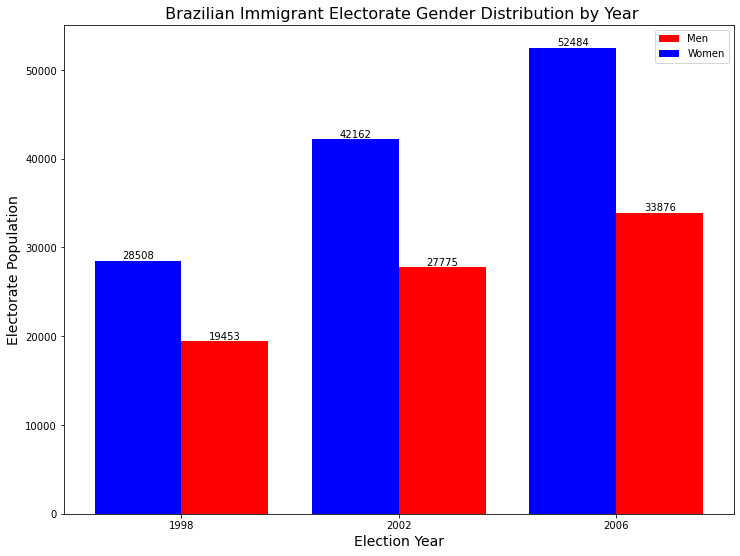

In [112]:
plot_genders(df_combined)